In [11]:
import funzioni02 as f2
import numpy as np
import datetime
import qiskit.ignis.mitigation.measurement as mc
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2022-03-17 20:39:30,318: Credentials are already in use. The existing account in the session will be replaced.


# Grafico fidelity vs. steps

### Creo il primo ciclo per realizzare tutti i circuiti da eseguire (a parte la calibrazione)

In [12]:
### definisco i parametri fissati per la realizzazione del grafico
shots=32000
reps=1  # al massimo 10
precision=40
tempo=np.pi
backend_aus=backend_sim
check=["4copy_check", [0,2,4,6]]
evo_type="column_evolution" # "column_evolution" or "complete_evolution" or "trotter_steps"
measure_mitigation = "yes"  #"yes" or "no"

### definisco i valori di steps corrispondenti ai punti che volgio acquisire
steps_range=[69,99]
n_s=len(steps_range)

### creo tutti i circuiti
qcs_steps=[]
qcs_steps_na=[]

### le liste qcs_steps e qcs_steps_na conterranno tutti i circuiti di evoluzione reps volte

for _ in range(reps):
    for steps in steps_range:
        
        if check!=[]:
            qcs_aus, qcs_na_aus = f2.evolution_tomo(type=evo_type, N_steps=steps, tempo=tempo, precision=precision, initial_state='110', check=check)
            qcs_steps.append(qcs_aus)
            qcs_steps_na.append(qcs_na_aus)

        else:
            qcs_aus = f2.evolution_tomo(type=evo_type, N_steps=steps, tempo=tempo, precision=precision, initial_state='110', check=check)
            qcs_steps.append(qcs_aus)
            qcs_steps_na.append(qcs_aus)


### Di seguito definisco i circuiti per la calibrazione

In [13]:
if measure_mitigation=="yes":
    qcs_calibs, meas_calibs = f2.calibration_cirquits(evo_type+"_remake", q_anc=check[1], check="yes")
    state_lables = f2.bin_list(3+len(check[1]))
# meas_calibs_0, state_lables = mc.complete_meas_cal(qubit_list=check[1]+[1,3,5])

### Eseguo tutti i circuiti (sia calibrazione che evoluzione)

In [14]:
jobs_evo=[]

for qcs in qcs_steps:
    job=execute(qcs, backend=backend_aus, shots=shots)
    jobs_evo.append(job)

if measure_mitigation=="yes":
    job_cal=execute(meas_calibs, backend=backend_aus, shots=shots)# initial_layout=[0,1,2,3,4,5])#check[1]+[1,3,5])
    job_cal_our=execute(qcs_calibs, backend=backend_aus, shots=shots)#, initial_layout=[0,1,2,3,4,5])

print("number of jobs: ", len(jobs_evo)+2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


number of jobs:  4


### if you wont open already existed jobs

In [15]:
#jobs_=backend.jobs(limit=30, start_datetime= "2022-02-18", end_datetime="2022-02-20")

#jobs_evo=[]

#j=len(jobs_)-1
#for i in range(len(jobs_)-2):
#    jobs_evo.append(jobs_[j])
#    j-=1

#job_cal=backend.retrieve_job(jobs_[1].job_id())
#job_cal_our =backend.retrieve_job("62233daa50a9af21709fb28d")

#print("number of jobs: ", len(jobs_evo)+2)


### Faccio la mitigazione sia con le ancille che sulla misura:
Le variabili che appaiono sotto contengono le seguenti cose:

    - new_res: risultati mitigati sia con le ancille che sulla misura con la calibrazione di qiskit
    - new_res_nm: risultati mitigati solo sulla misura sulle ancille
    - new_res_our: risultati mitigati sia con le ancille che sulla misura con la calibrazione nostra
    - new_res_not_mitigated: nessuna mitigazione

viene creata una matrice fids che contiene le fidelity dei vari jobs sulle rispettive righe e su ogni riga le colonne corrispondono in ordine a: risultati non mitigati, mitigati sono con le ancille, mitigati con ancille e qiskit calibration, mitigati con ancille e nostra calibrazione

In [16]:
if measure_mitigation=="yes":
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels=state_lables)
    meas_fitter_our = mc.CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)
else:
    meas_fitter = 0
    meas_fitter_our = 0

target_state = (One^One^Zero).to_matrix()


fids=np.zeros([n_s,reps,4])
fids_mean=np.zeros([n_s,4])
fids_dev=np.zeros([n_s,4])

i=0
for job in jobs_evo:
    
    if measure_mitigation == "yes" or check != []:
        new_res, new_res_nm = f2.mitigate(job.result(), Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter)
        new_res_our, new_res_nm = f2.mitigate(job.result(), Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_our)
        new_res_not_mitigated = f2.mitigate(job.result(), Measure_Mitig="no", ancillas_conditions=f2.bin_list(4))
    else:
        new_res_not_mitigated = job.result()

    fid = f2.fidelity_count(new_res_not_mitigated, qcs_steps_na[i], target_state)
    fids[i%n_s][i//n_s][0] += fid

    if check != []:
        fid = f2.fidelity_count(new_res_nm, qcs_steps_na[i], target_state)
        fids[i%n_s][i//n_s][1] += fid

        if measure_mitigation=="yes":
            fid = f2.fidelity_count(new_res, qcs_steps_na[i], target_state)
            fids[i%n_s][i//n_s][2] += fid

            fid = f2.fidelity_count(new_res_our, qcs_steps_na[i], target_state)
            fids[i%n_s][i//n_s][3] += fid
    
    i+=1

In [17]:
for i in range(4):
    for j in range(n_s):
        fids_mean[j,i]=np.mean(fids[j,:,i])
        fids_dev[j,i]=np.std(fids[j,:,i])

### Faccio il grafico della fidelity

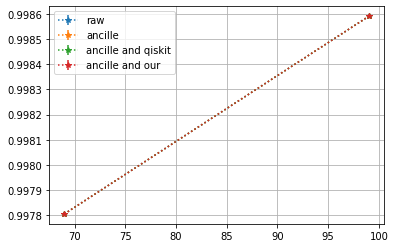

In [18]:
plt.errorbar(steps_range, fids_mean[:,0],fids_dev[:,0],linestyle=':',marker="*",label="raw")

if check!=[]:
    plt.errorbar(steps_range, fids_mean[:,1],fids_dev[:,1],linestyle=':',marker="*",label="ancille")

    if measure_mitigation=="yes":
        plt.errorbar(steps_range, fids_mean[:,2],fids_dev[:,2],linestyle=':',marker="*",label="ancille and qiskit")
        plt.errorbar(steps_range, fids_mean[:,3],fids_dev[:,3],linestyle=':',marker="*",label="ancille and our")
        
plt.legend()
plt.grid()

plt.show()

In [19]:
print(fids)

[[[0.99780458 0.99780458 0.99780458 0.99780458]]

 [[0.99859159 0.99859159 0.99859159 0.99859159]]]


### creo il file con i dati

In [20]:
if check==[0] or check==0:
    c_auss="noc" 
else:
    c_auss="yesc"

dati=("#%d_%d_%d_%.4f_%s_%s \n" %(shots, reps, precision, tempo, c_auss, evo_type))
nome="fid_vs_steps_10-03_01.txt"

#f = open("dati_esame_ruben/" + nome, "w")
f.write(dati)

for i in range(n_s):
    f.write("%d " %(steps_range[i]))
    for j in range(4):
        f.write("%.5f " %(fids_mean[i,j]))
        f.write("%.5f " %(fids_dev[i,j]))
    f.write("\n")

f.close()

NameError: name 'f' is not defined